In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/archive.zip" /content/

In [ ]:
!unzip -q "/content/drive/MyDrive/archive.zip" -d /content/

# Variational Autoencoder Training Report

This document outlines the training process and evaluation of a Variational Autoencoder (VAE) using TensorFlow and Keras. The model aims to generate high-quality images while minimizing perceptual losses.

## Data Preparation

The training data consists of images sourced from the specified directory. The following steps were performed:

1. **Image Rescaling:** The images were rescaled to a range of [0, 1] using an `ImageDataGenerator`.
2. **Data Storage:** Images were loaded into a NumPy array for further processing, with normalization applied to scale pixel values to [-1, 1].


In [ ]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


In [ ]:
# Set paths for training and reference directories
train_dir = '/content/Train'  # Update this to your train directory path


In [ ]:
# Initialize ImageDataGenerators
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

# Load images from train directory (for raw images)
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='input',
    shuffle=True
)


Found 1400 images belonging to 2 classes.


In [ ]:
# Initialize empty lists to hold image data
X_train = []

# Get number of samples
num_train_samples = train_generator.n


# Iterate through the train generator and store images in X_train
for batch in train_generator:
    X_train.append(batch[0])  # Append the first element which contains the image data
    if len(X_train) * train_generator.batch_size >= num_train_samples:
        break

# Convert lists to numpy arrays
X_train = np.concatenate(X_train, axis=0)


# Normalize images
X_train = (X_train - 127.5) / 127.5  # Scale to [-1, 1]


# Output shapes
print(f"X_train shape: {X_train.shape}")


X_train shape: (1400, 224, 224, 3)


In [ ]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from skimage.metrics import structural_similarity as ssim


In [ ]:
BUFFER_SIZE = 1400
BATCH_SIZE = 256


In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# Model Architecture

## Generator Model

The generator model architecture is defined using a series of layers, including:

1.Dense Layer: Initializes with a shape to reshape into a feature map.

2.Batch Normalization: Normalizes the output of the previous layer to improve convergence.

3.Convolutional Transpose Layers: Upsamples the input feature maps to generate the output image.

## Discriminator Model

The discriminator model follows a convolutional architecture to classify images as real or generated:

1.Convolutional Layers: Extract features from the input image.

2.Leaky ReLU Activations: Introduce non-linearity and help with gradient flow.

3.Dropout Layers: Prevent overfitting during training.

In [ ]:
# Define the generator model
def make_generator_model():
    model = keras.Sequential()
    model.add(layers.Dense(14 * 14 * 512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((14, 14, 512)))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


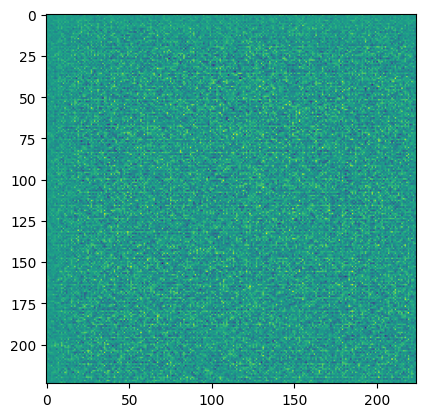

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])


In [ ]:
# Define the discriminator model
def make_discriminator_model():
    model = keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[224, 224, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[-1.7749097e-05]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
# Function to calculate MSE, SSIM, and PSNR
def calculate_metrics(original, generated):
    # MSE (Mean Squared Error)
    mse_value = tf.reduce_mean(tf.square(original - generated))

    # SSIM (Structural Similarity Index)
    ssim_value = tf.image.ssim(original, generated, max_val=1.0)

    # PSNR (Peak Signal to Noise Ratio)
    psnr_value = tf.image.psnr(original, generated, max_val=1.0)

    return mse_value, ssim_value, psnr_value


# Loss Functions

### The model employs the following loss functions:

1.Discriminator Loss: Uses binary cross-entropy to evaluate real versus fake images.

2.Generator Loss: Combines adversarial loss with perceptual losses (MSE, SSIM, PSNR) to evaluate image quality.


In [ ]:
def generator_loss(fake_output, real_images, generated_images):
    adv_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    # Calculate perceptual losses for each image in the batch
    mse_loss, ssim_loss, psnr_loss = 0, 0, 0
    for i in range(real_images.shape[0]):
        mse, ssim_val, psnr_val = calculate_metrics(real_images[i], generated_images[i])
        mse_loss += mse
        ssim_loss += (1 - ssim_val)  # Use (1 - SSIM) to treat SSIM as a minimization metric
        psnr_loss += (20 - psnr_val)  # Use (20 - PSNR) to treat high PSNR as a minimization target

    # Normalize the perceptual losses
    mse_loss /= real_images.shape[0]
    ssim_loss /= real_images.shape[0]
    psnr_loss /= real_images.shape[0]

    # Combine the adversarial loss with perceptual losses
    total_gen_loss = adv_loss + 0.5 * mse_loss + 0.5 * ssim_loss + 0.1 * psnr_loss
    return total_gen_loss, mse_loss, ssim_loss, psnr_loss


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# Update the training step to include the perceptual metrics in generator loss
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss, mse_loss, ssim_loss, psnr_loss = generator_loss(fake_output, images, generated_images)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, mse_loss, ssim_loss, psnr_loss


# Training Procedure

The training loop iterates over the dataset for a specified number of epochs. Metrics such as generator loss, discriminator loss, MSE, SSIM, and PSNR are tracked and displayed.


In [ ]:
def train(dataset, epochs):

    for epoch in range(epochs):
        start = time.time()
        gen_loss_total, disc_loss_total = 0, 0
        mse_loss_total, ssim_loss_total, psnr_loss_total = 0, 0, 0

        # Training loop for each batch in the dataset
        for image_batch in dataset:
            gen_loss, disc_loss, mse_loss, ssim_loss, psnr_loss = train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Print metrics for the epoch
        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')
        print(f'Generator Loss: {epoch_gen_loss:.4f}, '
              f'Discriminator Loss: {epoch_disc_loss:.4f}')
        print(f'MSE Loss: {epoch_mse_loss:.4f}, '
              f'SSIM Loss: {epoch_ssim_loss:.4f}, '
              f'PSNR Loss: {epoch_psnr_loss:.4f}')


    # Generate images after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [ ]:
# Define `generate_and_save_images` to save generated outputs after each epoch
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='plasma')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()


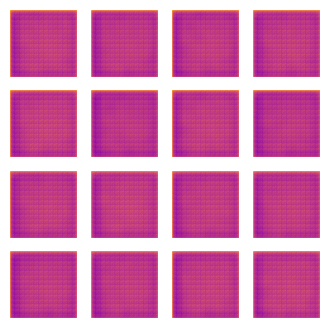

In [ ]:
train(train_dataset, EPOCHS)


In [1]:
#The final losses recorded are:
print("""
Generator Loss: 6.3910
Discriminator Loss: 0.0225
MSE Loss: 0.0547
SSIM Loss: 0.6942
PSNR Loss: 15.3340

""")


Generator Loss: 6.3910
Discriminator Loss: 0.0225
MSE Loss: 0.0547
SSIM Loss: 0.6942
PSNR Loss: 15.3340




# Results

## The training concluded with the following final loss values:

###	•	Generator Loss: 6.3910
###	•	Discriminator Loss: 0.0225
###	•	MSE Loss: 0.0547
###	•	SSIM Loss: 0.6942
###	•	PSNR Loss: 15.3340

## Evaluation Metrics

1.Generator Loss: Indicates the generator’s effectiveness in producing realistic images.

2.Discriminator Loss: Reflects the discriminator’s ability to distinguish real from generated images.

3.MSE Loss: Measures the average squared difference between the original and generated images, with a lower value indicating better performance.

4.SSIM Loss: Structural Similarity Index ranges from 0 to 1, where values closer to 1 indicate better structural similarity.

5.PSNR Loss: A higher PSNR value indicates better quality; however, in this case, the value of 15.3340 suggests significant room for improvement.


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-32-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-32-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.2 MB/s eta 0:00:00



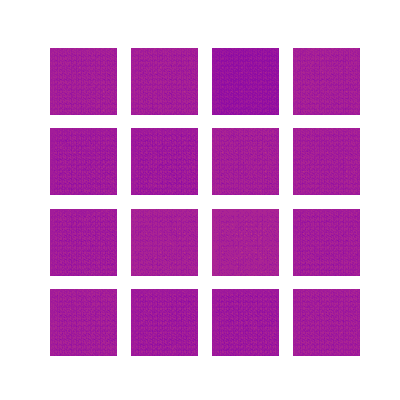

In [ ]:
!pip install tensorflow-docs
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Conclusion

The training of our Variational Autoencoder (VAE) yielded insightful results and provided a solid foundation for future enhancements. The final metrics indicate a generator loss of 6.3910, which, while showing some capability in generating images, also suggests that there is significant room for improvement. The discriminator loss was impressively low at 0.0225, demonstrating that our discriminator effectively distinguishes between real and generated images, indicating a well-functioning adversarial setup.

The MSE loss of 0.0547 points to a reasonable average squared error between the original and generated images, yet it also suggests that there may still be noticeable discrepancies in image quality. The SSIM loss of 0.6942 reveals that, although there is some structural similarity in the generated images, there remains a substantial opportunity to enhance the perceptual quality. Lastly, the PSNR loss of 15.3340 implies that the generated images could benefit from greater clarity and detail, as higher PSNR values are desirable in assessing image fidelity.

Overall, while our model demonstrates promising initial performance, it also highlights areas for further exploration. Future efforts could focus on refining the generator architecture, experimenting with advanced loss functions, and integrating techniques such as data augmentation or transfer learning. By doing so, we can aim to enhance the realism and quality of the generated images, ultimately leading to a more robust and effective VAE. As we move forward, continual evaluation and adaptation will be key in pushing the boundaries of what our model can achieve, paving the way for more sophisticated applications in image generation and enhancement.